In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Data_Cleaner import data_loader_main
import pysindy as psd
from SINDy import SINDy_Train

In [74]:
flow_all, _, occupancy_all, flow_dt, _, occupancy_dt = data_loader_main(csv_dict='Sim_Results/Ramp_MPC')
control_input = pd.read_csv('Results/Meter_Rate_MPC.csv')

In [75]:
control_input = control_input/10

In [76]:
# #remove initial 5 seconds
# flow_all = flow_all.iloc[5:,:]
# flow_dt = flow_dt.iloc[5:,:]
# occupancy_all = occupancy_all.iloc[5:,:]
# occupancy_dt = occupancy_dt.iloc[5:,:]
# control_input = control_input.iloc[5:,:]

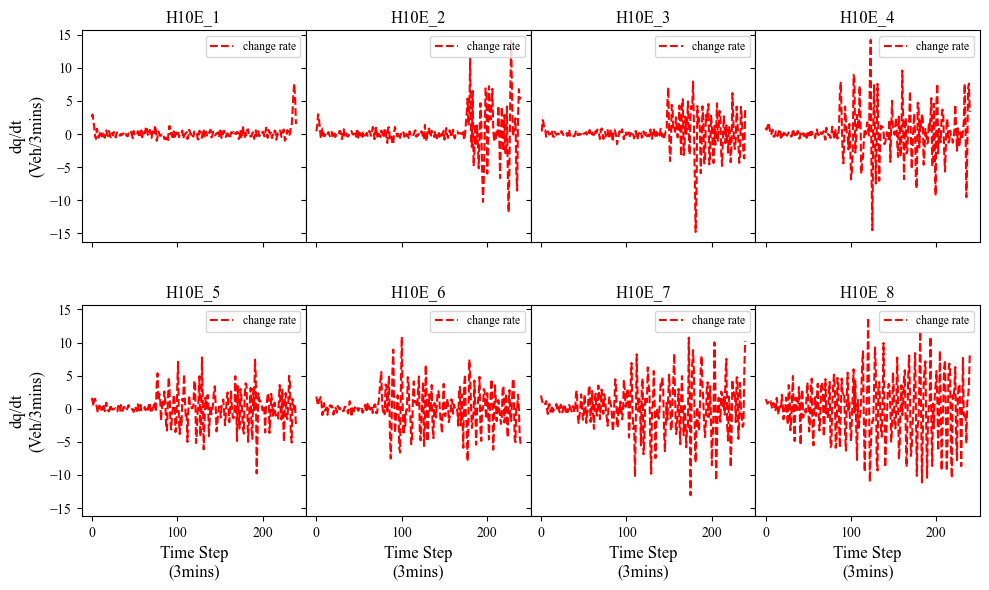

In [77]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(occupancy_dt.iloc[:, index], "--", label = 'change rate', color = "red")
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(occupancy_all.columns[index], fontsize=12)

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.show()
#fig.savefig('Figures/Flow_val.png', dpi=300)

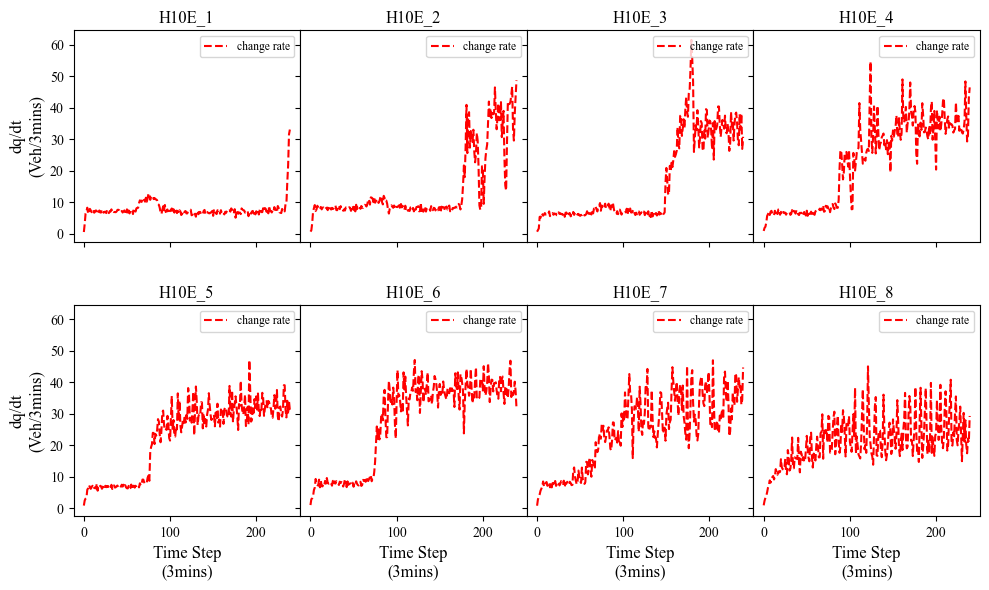

In [78]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(occupancy_all.iloc[:, index], "--", label = 'change rate', color = "red")
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.show()

In [79]:
train_obs = round(flow_all.shape[0]*0.6)

In [80]:
flow_train = flow_all.iloc[:train_obs,:]
flow_dt_train = flow_dt.iloc[:train_obs,:]
flow_val = flow_all.iloc[train_obs:, :]
flow_dt_val = flow_dt.iloc[train_obs:, :]
control_train = control_input.iloc[:train_obs,:]
control_val = control_input.iloc[train_obs:, :]

In [81]:
occupancy_train = occupancy_all.iloc[:train_obs,:]
occupancy_dt_train = occupancy_dt.iloc[:train_obs,:]
occupancy_val = occupancy_all.iloc[train_obs:, :]
occupancy_dt_val = occupancy_dt.iloc[train_obs:, :]

## SINDY

In [88]:
model = SINDy_Train(x = occupancy_all, dx = occupancy_dt, u = control_input, threshold= 0.005)

In [89]:
model.print()

(x0)' = 2.697 1 + -0.256 x0 + -0.142 x2 + 0.100 x3 + -0.104 x4 + 0.009 u0 + -0.013 u2 + 0.020 x0 x2 + -0.014 x0 x3 + 0.014 x0 x4
(x1)' = -11.673 1 + 1.254 x0 + 0.322 x1 + -0.457 x2 + -0.208 x3 + -0.399 x4 + 1.079 x5 + 0.042 x7 + -0.318 u0 + -0.572 u1 + 1.037 u2 + 0.030 u3 + -0.018 u5 + -0.101 u6 + 0.071 x0^2 + -0.030 x0 x3 + -0.027 x0 x4 + -0.007 x0 x6 + -0.021 x0 u2 + 0.010 x0 u6 + 0.018 x1 x4 + -0.010 x1 x5 + -0.015 x1 u0 + -0.014 x1 u1 + 0.028 x1 u2 + -0.019 x2 u0 + -0.011 x2 u1 + 0.032 x2 u2 + 0.015 x3 x4 + -0.016 x4^2 + -0.009 x4 x5 + 0.011 x4 x6 + -0.021 x4 u0 + 0.024 x4 u2 + 0.010 x5^2 + -0.007 x5 x6 + 0.033 x5 u0 + 0.013 x5 u1 + -0.052 x5 u2 + 0.019 u0^2 + 0.026 u0 u1 + -0.061 u0 u2 + -0.015 u0 u4 + 0.012 u1^2 + -0.047 u1 u2 + -0.014 u1 u4 + 0.051 u2^2 + 0.029 u2 u4
(x2)' = 2.606 1 + -0.305 x0 + 0.160 x1 + 0.490 x2 + -0.020 x3 + 0.516 x4 + -0.166 x5 + -0.192 x6 + -0.060 x7 + 0.044 u0 + -0.068 u2 + -0.046 x0^2 + 0.045 x0 x1 + -0.038 x0 x2 + -0.021 x0 x4 + 0.020 x0 x5 + 0.017 x0 

In [90]:
# Predict derivatives using the learned model
occupancy_dt_pred = model.predict(occupancy_all, u=control_input)

In [91]:
# theta = np.array(library.transform(pd.concat([flow_val, control_val], axis=1)))
# sindy_coeff = np.transpose(model.coefficients())
# flow_dt_pred_2 = np.matmul(theta, sindy_coeff)

In [92]:
flow_dt_val = flow_dt_val.reset_index(drop=True)
occupancy_dt_val = occupancy_dt_val.reset_index(drop=True)

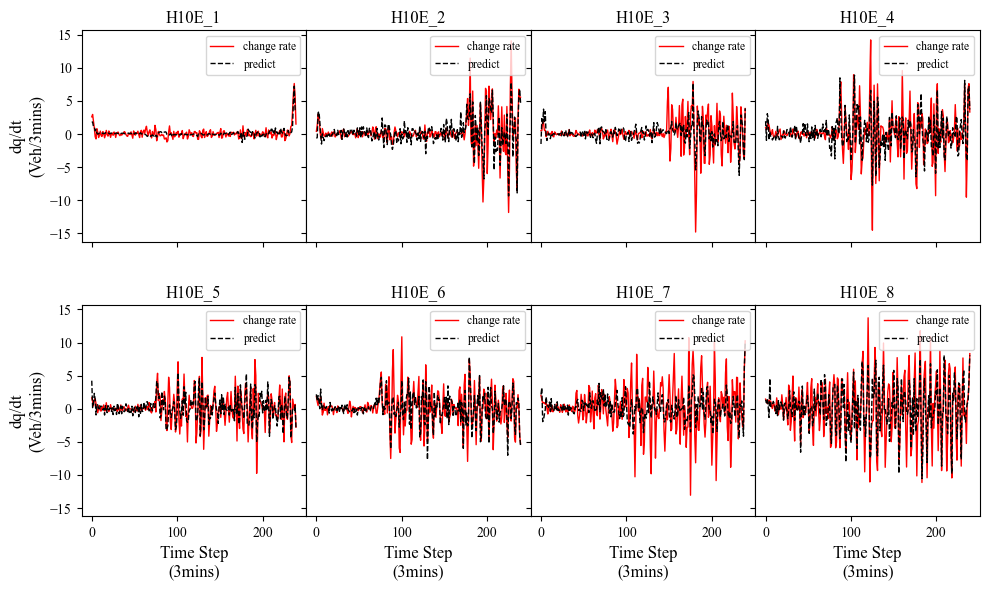

In [95]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(occupancy_dt.iloc[:, index], "-", label = 'change rate', color = "red",linewidth=1)
        axs[row, col].plot(occupancy_dt_pred[:, index], "--", label = 'predict', color = "black", linewidth=1)
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)
        # axs[row, col].set_ylim([-50, 50])

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig('Figures/SINDy_Predict.png', dpi=300)